<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/CNN_Sent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ тональности отзывов на товары

План проведения эксперимента:

1. Выбор модели для классификации отзывов на товары:
  
  * Baseline - LogisticRegression
  * cnn_rand
  * cnn_static
  * cnn_non_static
  * Bert finetuning

2. Обучение модели генерации ответов на отзывы

3. Inference на тестовом датасете

#0. Загрузка модулей, импорт библиотек и пользовательские функции

In [1]:
!pip install datasets

In [2]:
!pip install compress-fasttext

In [3]:
!pip install emoji==2.10.0

In [4]:
import compress_fasttext

In [5]:
from datasets import load_dataset
from datasets import get_dataset_split_names
from datasets import get_dataset_config_names

In [6]:
import emoji

In [7]:
import os
import re

import numpy as np
import pandas as pd
import random
import time
import nltk
nltk.download("all")
from nltk.tokenize import word_tokenize
from collections import defaultdict
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [8]:
from nltk.corpus import stopwords

In [9]:
ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'
)

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [11]:
def remove_emoji(text: str) -> str:
    """Вспомогательная функция для удаления смайликов из текста
    Args: text: str - исходный текст
    Return: str - текст без смайликов"""
    # Паттерн для поиска emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # эмодзи с улыбками
                               u"\U0001F300-\U0001F5FF"  # эмодзи с надписями и символами
                               u"\U0001F680-\U0001F6FF"  # транспортные эмодзи
                               u"\U0001F1E0-\U0001F1FF"  # флаги стран
                               u"\U00002500-\U00002BEF"  # китайские иероглифы
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    # Удаление emoji из текста
    return emoji_pattern.sub(r'', text)

In [12]:
def tokenize(texts: list[str]) -> tuple[list[list[str]], dict, int]:
    """Токенизация текста, создание словаря, поиск максимальной длины последовательности токенов.

    Args:
        texts (List[str]): список текстов

    Returns:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Добавляем токены <pad> and <unk> к словарю
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Создаем словарь из корпуса, начиная с индекса 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Добавляем токенизированное предложение к списку ( тексту)
        tokenized_texts.append(tokenized_sent)

        # Добавляем новы токен к словарю `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # ВЫчисляем новое значение `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [13]:
def encode(tokenized_texts, word2idx, max_len) -> np.array(int):
    """Добавляем в каждое предложение токены <PAD> до достижения длины max_length,
    кодируем токены их индексом в словаре.

    Args:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    Returns:
        input_ids (np.array): Массив индексов токенов размерностью (N, max_len).
        Будет подаваться на вход модели"""

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Паддинг предложения до max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Кодироване токенов индексами input_ids из словаря word2idx
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

In [14]:
stopwords = stopwords.words("russian")

In [15]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords
                  ])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

# 1. Загрузка датасетов

## Загрузка обучающего датасета

[Датасет для обучения и оценки - это RuReviews: An Automatically Annotated Sentiment Analysis Dataset for Product Reviews in Russian](https://github.com/sismetanin/rureviews/blob/master/women-clothing-accessories.3-class.balanced.csv)

> @INPROCEEDINGS{Smetanin-SA-2019,
> author={Sergey Smetanin and Michail Komarov},
> booktitle={2019 IEEE 21st Conference on Business Informatics (CBI)},
> title={Sentiment Analysis of Product Reviews in Russian using Convolutional Neural Networks},
> year={2019},
> volume={01},
> number={},
> pages={482-486},
> doi={10.1109/CBI.2019.00062},
> ISSN={2378-1963},
> month={July}
}

In [16]:
! wget -O --show-progress https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv -P /content/drive/MyDrive/DSU32

--2024-02-11 14:46:18--  https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21781685 (21M) [text/plain]
Saving to: ‘--show-progress’

                    100%[===================>]  20.77M   109MB/s    in 0.2s    

2024-02-11 14:46:18 (109 MB/s) - ‘--show-progress’ saved [21781685/21781685]



In [17]:
def to_mark(text):
  sent_dict = {"negative": 0, "neautral": 1, "positive": 2}
  return sent_dict[text]

In [18]:
df=pd.read_csv('/content/drive/MyDrive/DSU32/women-clothing-accessories.3-class.balanced.csv', sep='\t')
df['sentiment'] = df['sentiment'].apply(to_mark)
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0


In [19]:
df.to_csv('/content/drive/MyDrive/DSU32/dp_women-clothing-accessories.3-class.balanced.csv', sep=',', index=False)

In [20]:
# перемешиваем
d = pd.read_csv('/content/drive/MyDrive/DSU32/dp_women-clothing-accessories.3-class.balanced.csv')
df = d.sample(frac=1).reset_index(drop=True)
df.head()

,review,sentiment
0,товар уехал непонятно куда. спор не одобрили. ...,0
1,"Блузка очень красивая, за такие деньги просто ...",2
2,"Очень много торчащих ниток, но это исправляетс...",0
3,штаны хорошие. но есть один минус маломерят. в...,2
4,Брюки сидят идеально.Я сама по себе люблю высо...,2


In [21]:
texts = np.array(df['review'])
labels = np.array(df['sentiment'])

## Загрузка датасета для проверки качества модели

Датасет для проверки качества модели - выгружается с huggingface

In [22]:
from huggingface_hub import notebook_login
notebook_login()

In [23]:
get_dataset_split_names("TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['train']

In [24]:
dataset = load_dataset("TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset", split="train")

In [25]:
dataset[:1]

{'product_url': ['https://www.wildberries.ru/catalog/38709879/detail.aspx'],
 'product_title': ['Darya Selskaya / Рубашка офисная оверсайз'],
 'user_nickname': ['Нина'],
 'comment_date': ['11 марта, 18:39'],
 'comment_stars': [5],
 'comment_text': ['Качество  отличное, так же ,как и пошив. Все аккуратно. Рубашка очень понравилась. Закажу ещё в черном цвете'],
 'comment_likes_count': [0],
 'comment_dislikes_count': [0]}

In [26]:
df_to_pred = pd.DataFrame(dataset)

In [27]:
df_to_pred.to_csv('/content/drive/MyDrive/DSU32/wild_reviews.csv', index=False)

# 2. EDA и препроцессинг данных

## EDA обучающего датасета

In [28]:
df.info() # Обучающий датасет: 2 столбца, 90 тыс. записей, пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [29]:
df['sentiment'].unique() # 3 класса

array([0, 2, 1])

In [30]:
# Соотношение классов: датасет сбалансирован
df['sentiment'].value_counts()

0    30000
2    30000
1    30000
Name: sentiment, dtype: int64

In [31]:
def load_pretrained_vectors(word2idx, ft_model):
    """Load pretrained vectors and create embedding layers.

    Args:
        word2idx (Dict): словарь из корпуса текстов
        ft_model (CompressedFastTextKeyedVectors): Compressed FastText model

    Returns:
        embeddings (np.array): матрица мбеддингов размером (N, d),
        где N -размер словаря word2idx,  d - размерность эмбеддинга
    """

    print("Loading pretrained vectors...")

    # Инициализация эмбеддингов случайными числами
    d = ft_model.vector_size
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Загрузка предобученных векторов
    count = 0
    for word in tqdm(word2idx.keys()):
        if word in ft_model:
            count += 1
            embeddings[word2idx[word]] = ft_model[word]

    print(f"Найдено {count} / {len(word2idx)} предобученных векторов.")

    return embeddings

In [32]:
def data_loader(train_inputs: np.array, val_inputs: np.array,
                train_labels: np.array, val_labels: np.array,
                batch_size: int) -> tuple[DataLoader, DataLoader]:
    """Преобразование обучающей и оценочной выборок в to torch.Tensors и загрузка в
    DataLoader.
    """

    # Преобразование в torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Создание DataLoader для train
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Создание DataLoader для val
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

## EDA датасета для Inference

## Препроцессинг данных

In [33]:
def mark_to_label(number):
  if number < 3:
    return 0
  elif number == 3:
    return 1
  else:
    return 2

### Удаление смайликов, переименование столбцов, сохранение предобработанного датасета для Inference

In [34]:
df_to_pred['product'] = df_to_pred['product_title'].apply(lambda x: x.split('/')[1].strip() if '/'in x else x)
df_to_pred['brand'] = df_to_pred['product_title'].apply(lambda x: 'NoName' if '/' not in x else x.split('/')[0].strip())

In [35]:
df_to_pred.rename(columns={'comment_text': 'review', 'comment_stars': 'sentiment'}, inplace=True)

In [36]:
df_to_pred['emo']=df_to_pred['review'].apply(lambda x: emoji.distinct_emoji_list(x))
df_to_pred['emo']= df_to_pred['emo'].apply(lambda x:', '.join(x))

In [37]:
df_to_pred['review']=df_to_pred['review'].apply(remove_emoji)

In [38]:
df_to_pred['sentiment'] = df_to_pred['sentiment'].apply(mark_to_label)

###Распределение отзывов по тональности (0 - негативные, 1 -нейтральные, 2 - положительные

In [39]:
df_to_pred['sentiment'].value_counts() #реальные отзывы несбалансированы, но нам это не важно тк этот датасет используется только для inference

2    507
0     28
1     16
Name: sentiment, dtype: int64

In [40]:
df_to_pred[['review', 'sentiment']].to_csv('/content/drive/MyDrive/DSU32/dp_wild_reviews.csv', index=False)

###Распределение отзывов по брендам

In [41]:
df_to_pred['brand'].value_counts()

Me TradeMark           7
ARAVIA Professional    4
ARAVIA Laboratories    4
IERDI                  3
MY TOY                 3
                      ..
Текстилево             1
HousesStore            1
Дом'ОК                 1
GRINIX                 1
MONREMO                1
Name: brand, Length: 482, dtype: int64

In [42]:
df_to_pred[df_to_pred['sentiment'] == 0]['brand'].value_counts() # Отрицательные

Пояс для беременных.                 1
Loungewear ZEFIRKA                   1
НАКЛЕЙ-КИ                            1
FOXWELD                              1
Альпина. Книги                       1
StarLine                             1
Lab Royal                            1
DoktorMobil                          1
Bushido Pro                          1
Imba Energy                          1
Triviaa                              1
L.O.L. Surprise!                     1
Super Dance                          1
SBER                                 1
Izgip                                1
Mobi                                 1
Денежный ящик для кассы              1
UNICOM                               1
Fabia Monti                          1
NoName                               1
Miniza                               1
Массажёр для шеи и плеч NastStore    1
Light at home                        1
Efeet Collection                     1
BONDIBON                             1
IERDI                    

In [43]:
df_to_pred[df_to_pred['sentiment'] == 1]['brand'].value_counts() # Нейтральные

Henries                1
CROCS                  1
Alessio Nesca          1
ЛюЛюЛю                 1
РусБубон               1
ПРОТЭК                 1
CarpeDiem              1
ARAVIA Laboratories    1
Plat-ok                1
LeViTa                 1
L&V                    1
Home Zone              1
Нет износа             1
deco blik              1
OlArm                  1
АНДАНТЕ                1
Name: brand, dtype: int64

In [44]:
df_to_pred[df_to_pred['sentiment'] == 2]['brand'].value_counts() # Положительные

Me TradeMark           7
ARAVIA Professional    4
ARAVIA Laboratories    3
MY TOY                 3
NEWSKY                 3
                      ..
Миргайтанов.рф         1
YogaGuru               1
BIRLIKMEX              1
LAST CUP               1
MONREMO                1
Name: brand, Length: 444, dtype: int64

###Top-10 товаров с максимальным к-вом положительных отзывов

In [45]:
df_to_pred[df_to_pred['sentiment'] == 2]['product'].value_counts()[:10] # Положительные

Шары хром. Воздушные шарики набор 50 шт. хромовые, металлик…    3
Зарядное устройство Блок питания для iPhone для Android         3
Ковер комнатный 160х230 см в гостиную                           3
Присыпка тальк для тела, депиляции, шугаринга и маникюра        2
Держатель для телефона в машину с автовизиткой автомобильный    2
Ключница на стену деревянная для прихожей                       2
Толстовка с капюшоном                                           2
Свитшот для девочки мальчика детский в школу оверсайз одежда    2
Джинсы женские серые бананы с высокой посадкой базовые          2
Видеорегистратор зеркало Автомобильный регистратор 2 камеры     2
Name: product, dtype: int64

###Top-10 товаров с максимальным к-вом отрицательных отзывов

In [46]:
df_to_pred[df_to_pred['sentiment'] == 0]['product'].value_counts()[:10] # Отрицательные

Бандаж для беременных 4 в 1 Послеродовой дородовой корсет      1
Джемпер поло, женский джемпер теплый, кофта                    1
наклейка на банковскую карту галографическая jujutsu kaisen    1
НАБОР ПРИСПОСОБЛЕНИЙ ДЛЯ СВАРКИ "MULTI-6"                      1
Атлант расправил плечи (в 3 книгах )                           1
A93 ECO Ver.2                                                  1
Ароматизатор в машину                                          1
ЗЕРКАЛО АВТОМОБИЛЬНОЕ ЗАДНЕГО ВИДА ВАЗ БОКОВЫЕ ЛАДА            1
Автономный дизельный воздушный отопитель                       1
Энергетик без сахара напиток со вкусом мандарин в порошке      1
Name: product, dtype: int64

###Cписок наиболее часто испольуемых слов для каждой категории товара с положительными оценками (с построением WordClowd)

In [ ]:
import wordcloud
from collections import Counter
plt.rcParams['figure.figsize'] = [16, 9]

In [51]:
def create_ngrams(token_list, nb_elements):
    """
    Получение n-грамм для списка токенов

    Args:
      token_list : list - Список токенов
      nb_elements : int  n-gram

    Returns: Generator - генератор n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (' '.join(ngram) for ngram in ngrams)

In [52]:
def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens

    Args:
      list_worda: list - Список слов
      ngrams_number : int - К-во токенов в n-грамме
      number_top_words : int - длина  списка top_words

    Returns
      DataFrame:датафрейм с словами и частотами.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError('number of n-grams should be >= 1')
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent

In [53]:
from wordcloud import WordCloud

In [54]:
def make_word_cloud(text_or_counter, stop_words=None):
    """ Построение облака слов"""
    if isinstance(text_or_counter, str):
        word_cloud = WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
            word_cloud = WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

###Список наиболее часто испольуемых слов для каждой категории товара с отрицательными оценками (с построением WordClowd)

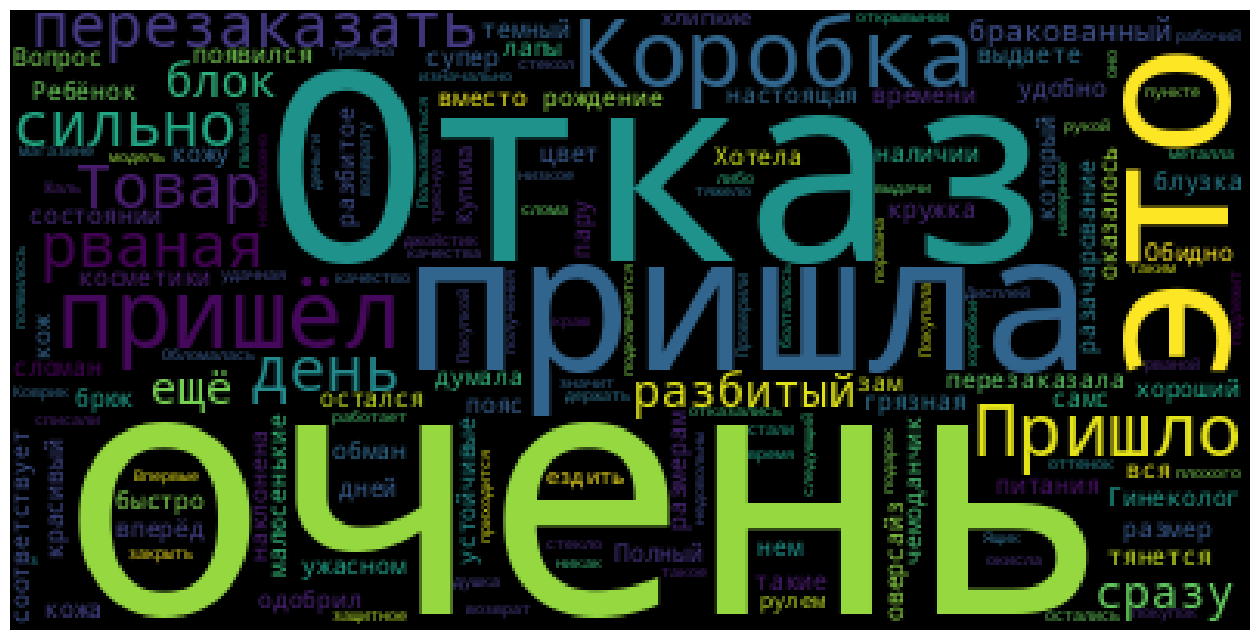

In [55]:
# Облако слов для отрицательных отзывов
text_data = ' '.join(df_to_pred[df_to_pred['sentiment'] == 0]['review'])
make_word_cloud(text_data, stop_words=stopwords)

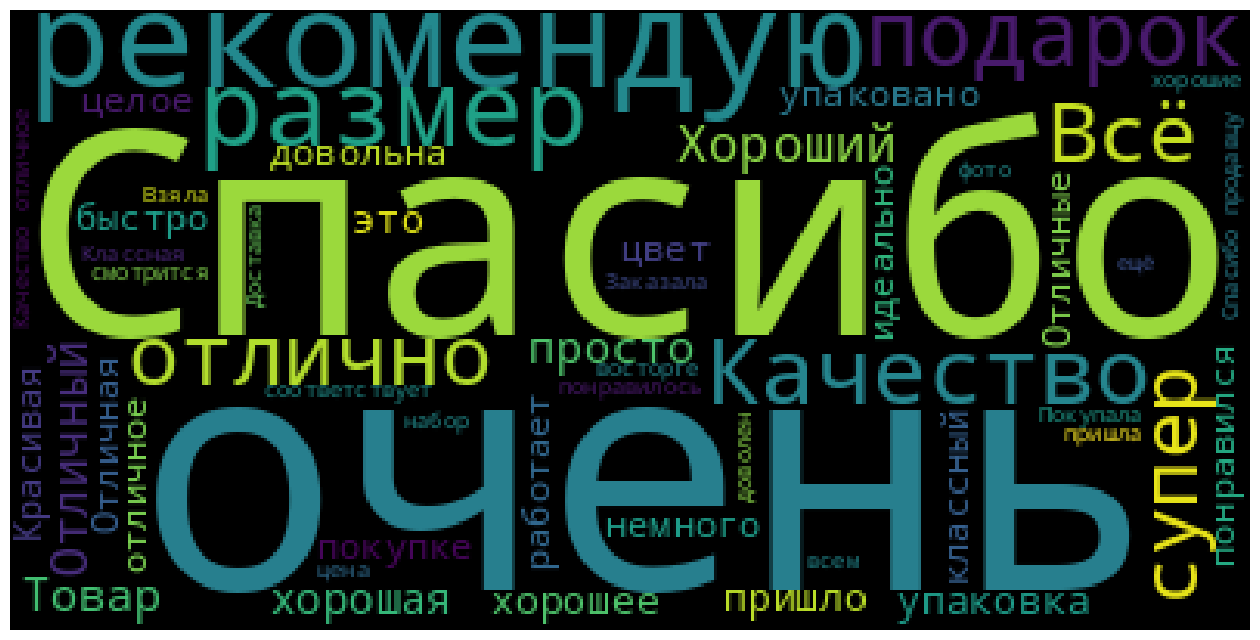

In [56]:
# Облако слов для положительных отзывов
text_data = ' '.join(df_to_pred[df_to_pred['sentiment'] == 2]['review'])
make_word_cloud(text_data, stop_words=stopwords)

Токенизация, построение словаря, кодирование токенов

In [57]:
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)



Tokenizing...



Загрузка предобученных эмбеддингов

In [58]:
embeddings = load_pretrained_vectors(word2idx, ft)
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


  0%|          | 0/86477 [00:00<?, ?it/s]

Найдено 86477 / 86477 предобученных векторов.


# 3. Работа с моделями

## BaseLine: TFIDF

In [57]:
%%time
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 8.38 s, sys: 249 ms, total: 8.62 s
Wall time: 8.75 s


In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
lr_model = LogisticRegression(solver='saga',penalty='l1', max_iter=300, random_state=42)
lr_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=300, penalty='l1', random_state=42, solver='saga')

In [60]:
y_pred = lr_model.predict(X_val_tfidf)

In [61]:
print(classification_report(y_pred, y_val, target_names =['negative', 'neautral', 'positive']))

              precision    recall  f1-score   support

    negative       0.70      0.73      0.71      5714
    neautral       0.67      0.62      0.64      6483
    positive       0.83      0.86      0.84      5803

    accuracy                           0.73     18000
   macro avg       0.73      0.74      0.73     18000
weighted avg       0.73      0.73      0.73     18000



In [62]:
import pickle

In [63]:
# save the model to disk
filename = '/content/drive/MyDrive/DSU32/models/lr_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))

## Модель CNN_NLP на базе сверточных слоев

### Разбиваем на train и val, загружаем в PyTorch DataLoader

In [59]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42)


In [60]:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]
batch_size = 50
num_classes = 3

In [61]:
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=batch_size)

### Конструктор

In [62]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):
        """
        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim).Optional
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding Слой , куда подаютсяя эмбеддинги; они инициализируются случайным образом или загружаются уже предобученные
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Сверточные слои
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Полносвязный слой и Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Конкатенация x_pool_list для заполнения полносвязного слоя.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Вычисление логитов Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

### Инициализация модели

In [63]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)

    cnn_model.to(device)

    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### Обучение и оценка модели

In [64]:
# задаем функцию потерь
loss_fn = nn.CrossEntropyLoss()

In [65]:
def set_seed(seed_value=42):
    """Устанавливаем seed для генератора псевдослучайных числе."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [66]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in tqdm(range(epochs)):
        # =======================================
        #               Training
        # =======================================

        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:

            val_loss, val_accuracy = evaluate(model, val_dataloader)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Best accuracy: {best_accuracy:.2f}%.")



In [67]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

#### Вариант 1: Случайная инициализация векторов слов

In [65]:
# CNN-rand
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.1,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=10)
torch.save(cnn_rand, '/content/drive/MyDrive/DSU32/models/cnn_rand')

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.829402   |  0.707759  |   67.52   |   39.97  
   2    |   0.689654   |  0.649901  |   70.82   |   37.39  
   3    |   0.637039   |  0.633665  |   71.63   |   37.76  
   4    |   0.596338   |  0.612438  |   72.46   |   37.79  
   5    |   0.567284   |  0.605611  |   72.68   |   38.81  
   6    |   0.540342   |  0.601685  |   72.86   |   37.57  
   7    |   0.513502   |  0.603081  |   73.37   |   37.46  
   8    |   0.489680   |  0.600042  |   73.37   |   37.79  
   9    |   0.463563   |  0.605617  |   73.63   |   40.60  
  10    |   0.441922   |  0.613177  |   73.20   |   36.84  


Best accuracy: 73.63%.


Результат сравним с результатом логистической регрессии, чуть-чуть лучше, переобучение начиная с 8 эпохи, затраты времени выше (> 280 c)

#### Вариант 2 - Используются compressed fastText эмбеддинги, которые замораживаются на период обучения

In [66]:
# CNN-static
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=10)
torch.save(cnn_rand, '/content/drive/MyDrive/DSU32/models/cnn_static')

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.768107   |  0.646743  |   71.18   |   16.87  
   2    |   0.633256   |  0.609798  |   73.04   |   17.63  
   3    |   0.598931   |  0.593130  |   73.27   |   16.35  
   4    |   0.576866   |  0.593354  |   74.09   |   16.23  
   5    |   0.560261   |  0.580348  |   74.28   |   16.23  
   6    |   0.545467   |  0.573975  |   74.62   |   16.18  
   7    |   0.531359   |  0.568651  |   74.89   |   16.25  
   8    |   0.518452   |  0.571247  |   74.79   |   16.27  
   9    |   0.509699   |  0.573453  |   74.52   |   16.33  
  10    |   0.496801   |  0.574294  |   74.94   |   16.24  


Best accuracy: 74.94%.


Результат лучше и достигается быстрее - меньше чем за 170 с. Переобучение начинается с 9 эпохи

#### Вариант 3: Тонкая настройка compressed fastText эмбеддингов в процессе обучения модели

In [67]:
# CNN-non-static
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.1,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=10)
torch.save(cnn_rand, '/content/drive/MyDrive/DSU32/models/cnn_non_static')

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

   1    |   0.762125   |  0.638073  |   71.33   |   61.40  
   2    |   0.622189   |  0.598918  |   73.32   |   60.76  
   3    |   0.586187   |  0.582713  |   73.82   |   61.16  
   4    |   0.562326   |  0.579242  |   74.64   |   64.99  
   5    |   0.544524   |  0.569001  |   74.78   |   63.69  
   6    |   0.527970   |  0.562040  |   74.96   |   62.12  
   7    |   0.513026   |  0.558262  |   75.32   |   62.91  
   8    |   0.498254   |  0.561061  |   75.48   |   63.57  
   9    |   0.487352   |  0.563382  |   75.01   |   61.98  
  10    |   0.471104   |  0.566864  |   75.20   |   61.54  


Best accuracy: 75.48%.


Модель работает дольше, чем в предыдущих случаях, из-за того, что эмбеддинги разморожены и также обучаются. Но и результат - лучший из всех. Переобучение начинается с 9 эпохи

Вариант 4: используются предобученные эмбеддинги, полученные из модели seara/rubert-tiny2-russian-sentiment

In [68]:
# возвращается усредненный эмбеддинг для каждого предложения в батче
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #Первый элемент model_output содержит эмбеддинги всех токенов
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
#Load AutoModel from huggingface model repository
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-russian-sentiment")
model = AutoModel.from_pretrained("seara/rubert-tiny2-russian-sentiment")

#Tokenize sentences

encoded_input = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=64, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
# CNN-seara
set_seed(42)
cnn_seara, optimizer = initilize_model(pretrained_embedding=sentence_embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_seara, optimizer, train_dataloader, val_dataloader, epochs=10)
torch.save(cnn_seara, '/content/drive/MyDrive/DSU32/models/cnn_seara')

По идее этот вариант должен быть очень хорошим, но выполнить его не удалось из-за ограничений на объем ОЗУ. Модель рассчитана на кол-во токенов 512, удается выполнить только с max_len=24, точность выходит существенно ниже, чем при использовании обычных CNN

### Inference

Проверка работы модели выполнялась на открытом датасете с huggingface:
[TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset](https://huggingface.co/datasets/TrainingDataPro/russian-marketplace-reviews-e-commerce-dataset)

In [ ]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=62, flag=False):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    if flag:
      print(f"This review is  {probs[0] * 100:.2f}% negative, {probs[1] * 100:.2f}% neutral & {probs[2] * 100:.2f}% positive.")
    return np.argmax(probs.detach().numpy())

In [ ]:
df_to_pred = pd.read_csv('/content/drive/MyDrive/DSU32/dp_wild_reviews.csv')
df_to_pred.head()


,review,sentiment
0,"Качество отличное, так же ,как и пошив. Все а...",1
1,"Отличные брюки. Ношу 48 размер, брюки взяла 46...",1
2,"Спасибо, продавцу за быструю доставку, упаковк...",1
3,"свитер просто БОМБАААА я счастлива) мягенький,...",1
4,Большимерят. Качество отличное,1


In [ ]:
texts_to_pred = np.array(df['review'])
labels_to_pred = np.array(df['sentiment'])

In [ ]:
predict('свитер просто БОМБАААА я счастлива) мягенький, цвет как я и ожидала ( на фотке освещение такое) единственный минус- рукава немного длинноваты, но это наверно потому что я слишком гном))) спасибо вам, осчастливили маленького гнома', flag=True)

This review is  0.54% negative, 12.17% neutral & 87.29% positive.


2

In [ ]:
model_list = []
model_list.append(("CNN-rand", cnn_rand))
model_list.append(("CNN-static", cnn_static))
model_list.append(("CNN-non-static", cnn_non_static))
model_list.append(("CNN-seara", cnn_seara))

In [ ]:
for name, model in model_list:
  predictions = []
  for text, label in zip(texts_to_pred, labels_to_pred):
    predictions.append(predict(text, model= model.to("cpu"), max_len=62, flag=False))
  print(f'-----{name}--------')
  print(classification_report(np.array(predictions),labels_to_pred, target_names=['negative', 'neutral', 'positive']))
  print()

-----CNN-rand--------
              precision    recall  f1-score   support

    negative       0.87      0.88      0.88     29503
     neutral       0.86      0.82      0.84     31744
    positive       0.92      0.96      0.94     28753

    accuracy                           0.88     90000
   macro avg       0.88      0.89      0.88     90000
weighted avg       0.88      0.88      0.88     90000


-----CNN-static--------
              precision    recall  f1-score   support

    negative       0.76      0.80      0.78     28537
     neutral       0.77      0.69      0.73     33287
    positive       0.87      0.93      0.90     28176

    accuracy                           0.80     90000
   macro avg       0.80      0.81      0.80     90000
weighted avg       0.80      0.80      0.80     90000


-----CNN-non-static--------
              precision    recall  f1-score   support

    negative       0.76      0.81      0.79     28135
     neutral       0.79      0.70      0.74     33947

Inference на предобученной модели с huggingface

In [1]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
df_to_pred = pd.read_csv('/content/drive/MyDrive/DSU32/dp_wild_reviews.csv')
df_to_pred.head()

,review,sentiment
0,"Качество отличное, так же ,как и пошив. Все а...",2
1,"Отличные брюки. Ношу 48 размер, брюки взяла 46...",2
2,"Спасибо, продавцу за быструю доставку, упаковк...",2
3,"свитер просто БОМБАААА я счастлива) мягенький,...",2
4,Большимерят. Качество отличное,2


In [3]:
texts_to_pred, labels_to_pred = df_to_pred['review'].values, df_to_pred['sentiment'].values

In [5]:
from sklearn.metrics import classification_report

In [6]:
# нужно уменьшить длину в токенах до максимальной 512.
# Т.к в пайплайне huggingfасе встроенный токенизатор, нужно обрезать тексты за пределами
truncated_texts_to_pred = [' '.join(text.split()[:512]) for text in texts_to_pred]

# Это словарь для перевода названий в метки классов
sent_dict ={'negative': 0, 'neutral':1, 'positive': 2}
predictions = [model(text)[0]['label'] for text in truncated_texts_to_pred]
predictions_ =[sent_dict[x] for x in predictions]

print(classification_report(np.array(predictions_),labels_to_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.50      0.54      0.52        26
     neutral       0.62      0.12      0.20        83
    positive       0.87      1.00      0.93       442

    accuracy                           0.85       551
   macro avg       0.67      0.55      0.55       551
weighted avg       0.82      0.85      0.80       551



Получился интересный результат - качество прогноза на тестовом датасете выше у самой первой модели. Модель с Huggingface, обученная на том же корпусе + дополнительные корпусы, показала при inference результат хуже. Видимо, причина в том, что эмбеддинги, на которых обучалась 2 и 3 модели, строились уже исходя из конкретного корпуса текста, который значиетльно меньше, чем корпус, на котором обучалась модель fasttext

https://captum.ai/tutorials/IMDB_TorchText_Interpret   - добавить код по интерпретации результатов прогнозирования ( можно посмотреть, какие именно слова и в какой степени повлияли на результат прогноза)

# Генерация ответов на отрицательные отзывы

1. генерация с помощью gpt2
2. генерация с помощью  gpt3.5

In [7]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
model = GPT2LMHeadModel.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [8]:
def get_responce(text):
  input_ids = tokenizer.encode(text, return_tensors='pt')

  tokens = model.generate(
      input_ids,
      max_length=70,
      repetition_penalty=5.0,
      do_sample=False,
      top_k=5,
      top_p=0.95,
      temperature=2.0,
      num_beams=5,
      no_repeat_ngram_size=4,
  )
  responce = ' '.join([tokenizer.decode(t) for t in tokens])
  return responce

In [9]:
neg_texts = df_to_pred[df_to_pred['sentiment']==0].values

In [10]:
neg_texts[0].tolist()[0]

'Гинеколог не одобрил пояс, да и мне не очень удобно в нем'

In [11]:
responces = []
for text in neg_texts:
  responces.append(get_responce(text.tolist()[0].split('.')[0]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `2.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:396: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


In [12]:
len(responces)

28

In [13]:
responces

['Гинеколог не одобрил пояс, да и мне не очень удобно в нем ковыряться.\n\n—\xa0А что это такое?\xa0— спросил я у врача.\n\nОн посмотрел на меня с удивлением:\n\n–\xa0Это значит, что ты можешь делать все, что тебе заблагорассудится!\n\nЯ',
 'Очень сильно тянется, размер один, супер оверсайз, отказоустойчивый.  Но это не значит, что у меня нет проблем с ним.  Я просто хочу сказать, что я очень доволен покупкой этой модели и буду рекомендовать ее всем своим знакомым. \n\n В этом разделе Вы можете ознакомиться с отзывами клиентов нашего интернет-',
 'Отказ, вместо брюк пришла блузка, перезаказала туфли на высоком каблуке и вышла из дома.\n\n—\xa0Что-то не так?\xa0— спросила она у своего спутника.\n\nТот пожал плечами:\n\n–\xa0Да нет, все в порядке. Просто мне нужно кое-что проверить.\n\nОн подошел к',
 'Полный обман, это не настоящая кожа, а хороший кожезаменитель.  Если вы хотите, чтобы ваша кожа была гладкой и шелковистой, то вам нужно использовать только натуральные косметические средс

Ответы вышли далекие от идеала

Генерация отзывов с помощью gpt3.5

In [14]:
! pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [15]:
import openai
from openai import OpenAI

In [16]:
def get_responce(review):
    client = OpenAI()
    prompt = f"Напиши ответ на отзыв '{review}'.В ответе вырази понимание проблемы и сообщи о предпринимаемых мерах по устранению проблемы. Уложись в 3 предложения"
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
      ]
    )
    return response.choices[0].message.content

In [18]:
from tqdm.notebook import tqdm

In [25]:
import os

# Получение значения переменной окружения OPENAI_API_KEY
openai_api_key = os.environ.get("OPENAI_API_KEY")

# Проверка, что переменная определена
if openai_api_key:
    # Используйте значение переменной
    print('Ключ установлен')
else:
    print("Переменная окружения OPENAI_API_KEY не определена.")

Ключ установлен


In [ ]:
for i, review in tqdm(enumerate(neg_texts)):
    print(f'{i}: Отзыв: {review} \n Ответ: {get_responce(review)}')

0it [00:00, ?it/s]

0: Отзыв: ['Гинеколог не одобрил пояс, да и мне не очень удобно в нем' 0] 
 Ответ: Понимаем, что вы не ощущаете комфорта при использовании пояса и получили отрицательную обратную связь от гинеколога. Мы принимаем эту информацию во внимание и работаем над улучшением нашего пояса, чтобы обеспечить лучший комфорт и поддержку вашего здоровья. Благодарим вас за обратную связь, которая помогает нам улучшить нашу продукцию.
1: Отзыв: ['Очень сильно тянется, размер один, супер оверсайз, отказ' 0] 
 Ответ: Понимаем, что возникла проблема с размером товара и его качеством. Мы уже работаем над устранением данного недоразумения и предпринимаем все необходимые меры для улучшения процесса производства. Ценим ваш отзыв и готовы предложить вам возмещение или замену товара.
2: Отзыв: ['Отказ, вместо брюк пришла блузка, перезаказала.' 0] 
 Ответ: Приносим извинения за неудобства, связанные с получением неправильного товара. Мы полностью понимаем ваше разочарование и готовы предпринять необходимые действ